# Example usage of the Hybrid Model

In [1]:
# imports
import jax
import jax_cfd.base.equations as eqtns
import jax_cfd.base as cfd
import jax.numpy as jnp
import numpy as np
import xarray
import seaborn
import pickle
import haiku as hk
import jax_cfd.base.grids as grids

from diego_model_utils import SaveObject, forward_pass_module

In [2]:
## forcings

## Here are different types of forcing functions/conditions

# Linear force due to uniform pressure gradient
def pressure_gradient_forcing(pressure_gradient: float):
  
  def forcing(v):
    force_vector = (pressure_gradient, 0)
    return tuple(cfd.grids.GridArray(f * jnp.ones_like(u.data), u.offset, u.grid)
                 for f, u in zip(force_vector, v))
  
  return forcing

# Turbulent forcing (kolmogorov forcing)
def turbulentForcing(grid):
    return cfd.forcings.simple_turbulence_forcing(grid, constant_magnitude = 0.5, linear_coefficient = -0.8) # params specified in jax-cfd for 2D turbulence

In [3]:
# intialising problem

#grid
#bcs
#initial velocities
#forcing

size = (256,64)
domain = ((0, 8), (0, 2))

density = 1. ### original 1.
viscosity = 1e-4 # kinematic viscosity ### original 1e-3

pressure_gradient = 2e-3  # uniform dP/dx ### original 2e-3


grid = cfd.grids.Grid(size, domain = domain)


velocity_bc = (cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
               cfd.boundaries.channel_flow_boundary_conditions(ndim=2))

pressure_solve = cfd.pressure.solve_fast_diag_channel_flow ### solve_fast_diag_channel_flow OR solve_cg

vx_fn = lambda x, y: jnp.zeros_like(x) 
vy_fn = lambda x, y: jnp.zeros_like(x)

max_velocity = 1.
cfl_safety_factor = 0.5

# time steps per output
# inner_steps = 1  ## defined below

# number of outputs
# outer_steps = 1000   ## defined below to allow the toTime method to work

forcing = lambda pressure_gradient, grid :  cfd.forcings.sum_forcings(
        pressure_gradient_forcing(pressure_gradient),
        #turbulentForcing(grid),
        cfd.forcings.taylor_green_forcing(grid, scale = 0.05)
        #cfd.forcings.kolmogorov_forcing(grid)
        #cfd.forcings.linear_forcing(grid,1.01)
        #cfd.forcings.filtered_forcing(grid = grid, spectral_density = 1)
        #cfd.forcings.filtered_linear_forcing(grid=grid, upper_wavenumber = 2, coefficient = 1, lower_wavenumber = 1)
)

#######################
# # Evaluate forcing and grid
# for i in range(len(simSpecs)):
#     simSpecs[i]['grid'] = grid = cfd.grids.Grid(simSpecs[i]["size"], 
#                                                               domain=simSpecs[i]["domain"])
#     simSpecs[i]['forcing'] = simSpecs[i]['forcing'](pressure_gradient = simSpecs[i]['pressure_gradient'], 
#                                          grid = simSpecs[i]['grid']
#       )
#######################


forcing = forcing(pressure_gradient = pressure_gradient, 
                  grid = grid)

In [4]:
# finish setting up simulation
v0 = cfd.initial_conditions.initial_velocity_field(
       velocity_fns = (vx_fn, vy_fn),
       grid = grid,
       velocity_bc = velocity_bc,
       pressure_solve = pressure_solve,
       iterations=5)




## divergence check
div = cfd.finite_differences.divergence(v0)
np.testing.assert_allclose(div.data, 0)

# calculate stable timestep (do we need to save this?)
dt = cfd.equations.stable_time_step(max_velocity, 
                                    cfl_safety_factor, 
                                    viscosity, 
                                    grid)


## define convection function
def convect(v):
  return tuple(
      cfd.advection.advect_van_leer(u, v, dt) for u in v)


# time steps per output
inner_steps = 100

# Option ONE
outer_steps = 50

# Option TWO
toTime = False
if toTime:
    target_sim_time = 15 #in time
    outer_steps = target_sim_time//(inner_steps*dt)
    


## Defining and choosing from a number of different numerical step functions

In [5]:
# define function to advance one timestep

# Semi-implicit Navier Stokes
NS_step_functions = {    
    "navier_stokes_explicit_terms" : cfd.equations.navier_stokes_explicit_terms(
                                                density=density,
                                                viscosity=viscosity,
                                                dt=dt,
                                                grid=grid,
                                                convect=convect,
                                                forcing= forcing
    ),
    
    "semi_implicit_navier_stokes" : cfd.equations.semi_implicit_navier_stokes(
                                                density=density,
                                                viscosity=viscosity,
                                                dt=dt,
                                                grid=grid,
                                                convect=convect,
                                                pressure_solve = pressure_solve,
                                                forcing= forcing
    ),
    
    "implicit_diffusion_navier_stokes" : cfd.equations.implicit_diffusion_navier_stokes(
                                                density=density,
                                                viscosity=viscosity,
                                                dt=dt,
                                                grid=grid,
                                                convect=convect,
                                                pressure_solve = pressure_solve,
                                                forcing= forcing
    )
        
}


NS_step = NS_step_functions["semi_implicit_navier_stokes"]

## Defining the ML section of the solver


In [6]:
# composing (joining) two functions (output of one is input of the other)
def compose(second_fun, first_fun):
        return lambda x : second_fun(first_fun(x))

In [7]:
#substitute the next two blocks by importing from diego_model_utils

In [8]:
# class SaveObject():
# #     def __init__(self,params):
# #         self.params = params
    
#     def save_params(self,params):
#         self.params = params
    
#     def save_forward_pass_params(self,num_output_channels,ndim,tower_module):
#         self.num_output_channels = num_output_channels
#         self.ndim = ndim
#         self.tower_module = tower_module
    
#     def make_forward_pass(self):
#         self.forward_pass = forward_pass_module(num_output_channels = self.num_output_channels, 
#                                                     ndim = self.ndim,
#                                                     tower_module = self.tower_module)
        
#     def preprocess(self):
#         self.forward_pass = hk.without_apply_rng(hk.transform(self.forward_pass))

In [9]:
# def forward_pass_module(
#     num_output_channels,
#     ndim,
#     tower_module
# ):
#     """Constructs a function that initializes tower and applies it to inputs."""
#     global forward_pass ## this is to make the forward_pass_module pickleable
#     def forward_pass(inputs):
#         return tower_module(num_output_channels, ndim)(inputs)

#     return forward_pass

In [10]:
# Load corrector/inference network
save_path = "./models/sample.pickle"
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    loaded.make_forward_pass()
    loaded.preprocess()

In [12]:
def scale(input, min=0, max=1):
    
    if min>max:
        raise(ValueError("Min and max may be the wrong way around"))
    
    if min<0:
        og_min = min
        max += -min
        min = 0

    
    input += (min-np.min(input))
    input /= (np.max(input)/max)
    
    try:
        input += og_min
    except:
        pass
    return input

In [13]:
def dummy_corrector(v):
    return v

In [14]:
def corrector(v):
    
    #have to scale inputs
#     scaled_v = scale(v)
    the_input = jnp.dstack([v[0].data,v[1].data])
#     originalMin = jnp.min(the_input)
#     originalMax = jnp.max(the_input)
    
    
    pred = loaded.forward_pass.apply(loaded.params,the_input)
    
    
    #have to scale preds back
#     the_input = scale(the_input, min= originalMin, max = originalMax)
    
    return (grids.GridVariable(array = grids.GridArray(data = pred[:,:,0], offset = v[0].offset, grid = v[0].grid),
                               bc = v[0].bc),
            grids.GridVariable(array = grids.GridArray(data = pred[:,:,1], offset = v[1].offset, grid = v[1].grid),
                               bc = v[1].bc))

In [15]:
#building the single step block
single_step = cfd.funcutils.repeated(compose(NS_step,corrector),
                       steps=inner_steps)
# single_step = cfd.funcutils.repeated(NS_step, steps=inner_steps)

In [16]:
# jax.jit function enables execution on CPU/GPU/TPU
rollout_fn = jax.jit(cfd.funcutils.trajectory(
    single_step, outer_steps, start_with_input=True))

In [17]:
## compute trajectory
%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 4min 2s, sys: 10.9 s, total: 4min 13s
Wall time: 22.5 s


In [18]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(1, outer_steps + 1)
    }
)

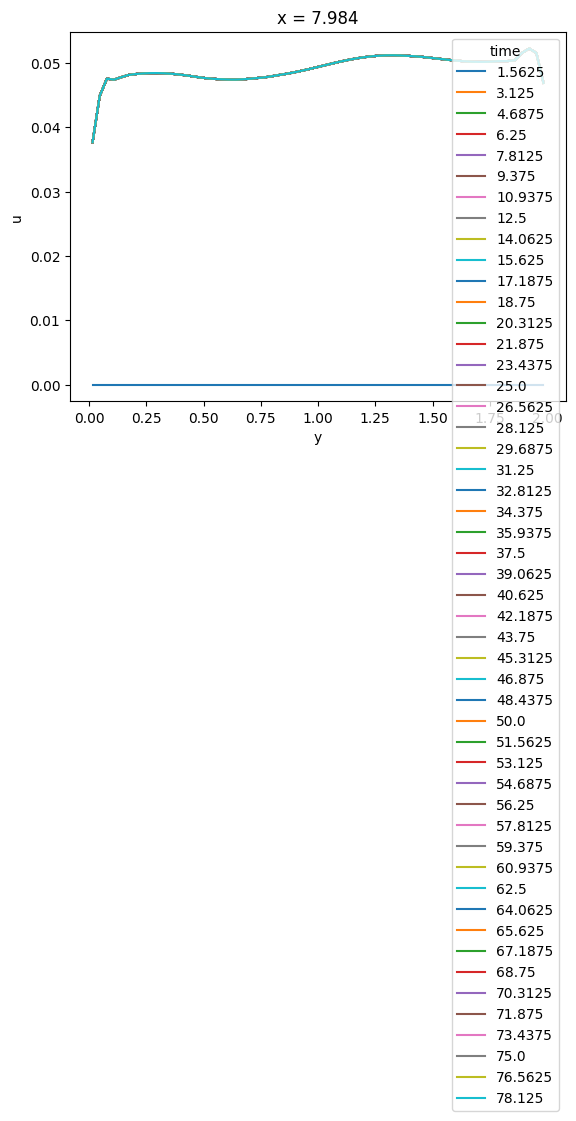

In [19]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds.pipe(vx_at_x_upper_boundary).plot(hue='time')

<AxesSubplot: >

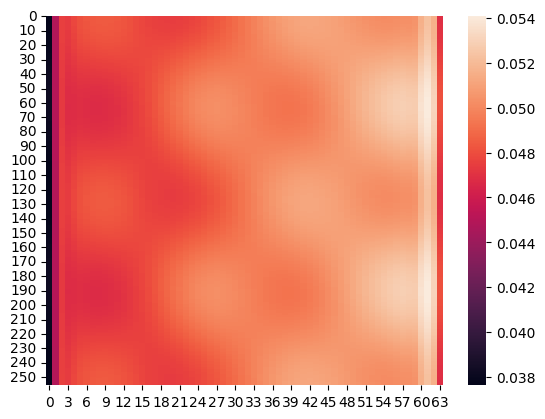

In [20]:
seaborn.heatmap(ds.u.isel(time=7))

In [105]:
# define way to get time derivative loss

In [13]:
# define way to get integrated solution loss

In [27]:
for i in range(5):
    loss = i
    val_loss = 2*i
    print("\tMSE : {:.6f}".format(loss), end='\t')
    print("\tval_loss : {:.6f}".format(val_loss), end='')
    print("\n")

	MSE : 0.000000		val_loss : 0.000000

	MSE : 1.000000		val_loss : 2.000000

	MSE : 2.000000		val_loss : 4.000000

	MSE : 3.000000		val_loss : 6.000000

	MSE : 4.000000		val_loss : 8.000000



In [21]:
#running dummy_corrector sim
#building the single step block
single_step = cfd.funcutils.repeated(compose(NS_step,dummy_corrector),
                       steps=inner_steps)
# single_step = cfd.funcutils.repeated(NS_step, steps=inner_steps)

# jax.jit function enables execution on CPU/GPU/TPU
rollout_fn = jax.jit(cfd.funcutils.trajectory(
    single_step, outer_steps, start_with_input=True))

## compute trajectory
%time _, trajectory = jax.device_get(rollout_fn(v0))

# load into xarray for visualization and analysis
ds_dummy = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(1, outer_steps + 1)
    }
)

CPU times: user 11.2 s, sys: 1.25 s, total: 12.4 s
Wall time: 6.6 s


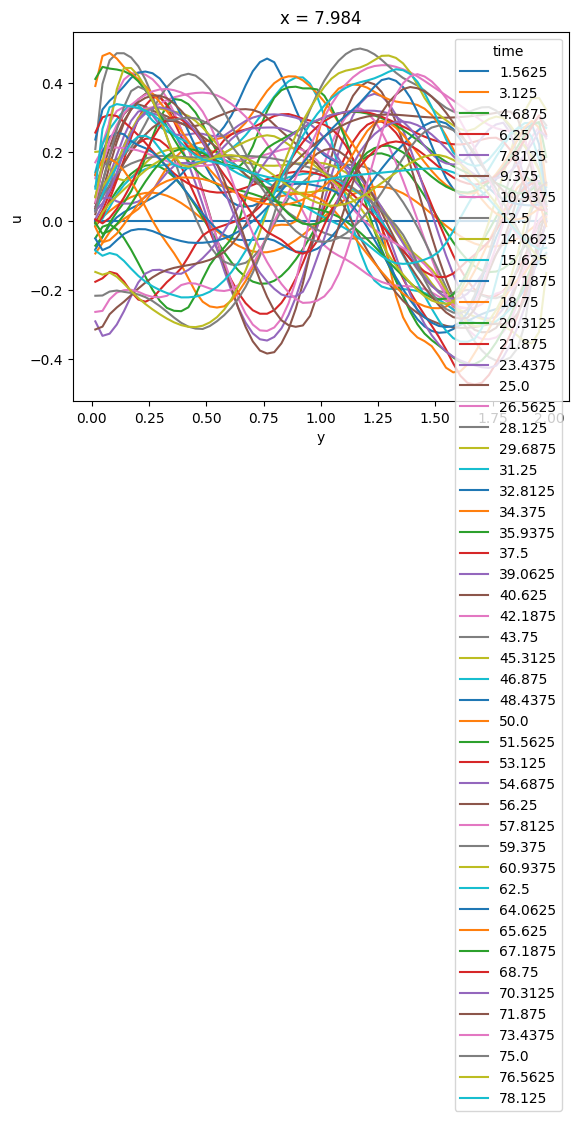

In [22]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds_dummy.pipe(vx_at_x_upper_boundary).plot(hue='time')

<AxesSubplot: >

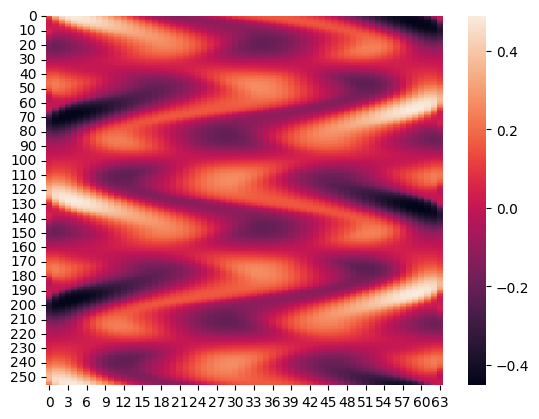

In [23]:
seaborn.heatmap(ds_dummy.u.isel(time=7))